In [149]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.utils import check_random_state
from scipy.optimize import fmin_l_bfgs_b
from tqdm import tqdm

import jax
import jax.numpy as jnp

from picard import amari_distance

from multiviewica_delay import multiviewica_delay

# parameters

In [150]:
m = 10
p = 5
n = 600
max_shift = 5
max_dilation = 1.01
noise_data = 0.01
noise_model = 1
noise_W_list = 0.1
random_state = 732671

# apply delay functions

In [151]:
def apply_both_delays_1d_cyclic(
    s,
    a,
    b,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
    shift_before_dilation=True,
):
    n = len(s)
    max_delay = (np.ceil((n + max_shift) * max_dilation) - n).astype("int")
    s_extended = jnp.concatenate([s[n-max_delay:], s, s[:max_delay]])
    t_extended = jnp.arange(n + 2 * max_delay) - max_delay - t0
    t = jnp.arange(n) - t0
    if shift_before_dilation:
        t_ab = (t - b) * a / dilation_scale
    else:
        t_ab = t * a / dilation_scale - b
    s_ab = jnp.interp(x=t_ab, xp=t_extended, fp=s_extended, left=0, right=0)
    return s_ab

def apply_both_delays_2d_cyclic(
    S,
    a,
    b,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
    shift_before_dilation=True,
):
    p, n = S.shape
    max_delay = (np.ceil((n + max_shift) * max_dilation) - n).astype("int")
    S_extended = jnp.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_extended = jnp.arange(n + 2 * max_delay) - max_delay - t0
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    if shift_before_dilation:
        T_ab = ((T.T - b) * a / dilation_scale).T
    else:
        T_ab = (T.T * a / dilation_scale - b).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_extended, fp=S_extended[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(
    S_list,
    A,
    B,
    max_shift=0.,
    max_dilation=1.,
    dilation_scale=1.,
    t0=0,
    shift_before_dilation=True,
):
    Y_list = jnp.array(
        [apply_both_delays_2d_cyclic(
            S_list[i], a=A[i], b=B[i], max_shift=max_shift, max_dilation=max_dilation, 
            dilation_scale=dilation_scale, t0=t0, shift_before_dilation=shift_before_dilation) 
         for i in range(len(S_list))])
    return Y_list

# generate data

In [152]:
def sources_generation_zero_mean(p, n, rng=None):
    low_mean = n / 4
    high_mean = 6 * n / 10
    means = (np.arange(p) + rng.uniform(size=p)) * (high_mean - low_mean) / p + low_mean
    rng.shuffle(means)
    variances = rng.randint(n // 25, n // 10, size=p)
    heights = rng.uniform(0.6, 1.4, size=p)

    def f(x, mean, var):
        t = (x - mean) / var
        t[t > 0] /= 2
        s = -t/2 * np.exp(-t ** 2)
        s[s < 0] /= 2
        return s

    S = np.array(
        [height * f(np.arange(n), mean, var)
         for height, mean, var in zip(heights, means, variances)])
    return S

def data_generation(
    m,
    p,
    n,
    max_shift=0.,
    max_dilation=1.,
    noise_data=0.05,
    t0=0,
    rng=None,
):
    S = sources_generation_zero_mean(p, n, rng)
    S_list = np.array([S] * m) + noise_data * rng.randn(m, p, n)
    A_list = rng.randn(m, p, p)
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    S_list = apply_both_delays_3d_cyclic(
        S_list, A=dilations, B=shifts, max_shift=max_shift, max_dilation=max_dilation,
        dilation_scale=1., t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

In [153]:
# generate data
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = data_generation(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    t0=0,
    rng=rng,
)

# plot

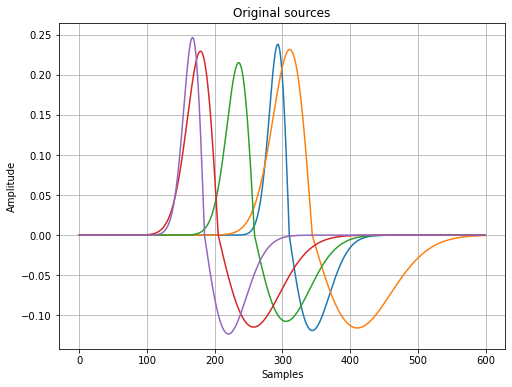

In [154]:
plt.figure(figsize=(8, 6))
plt.plot(S.T)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Original sources")
plt.grid()
plt.show()

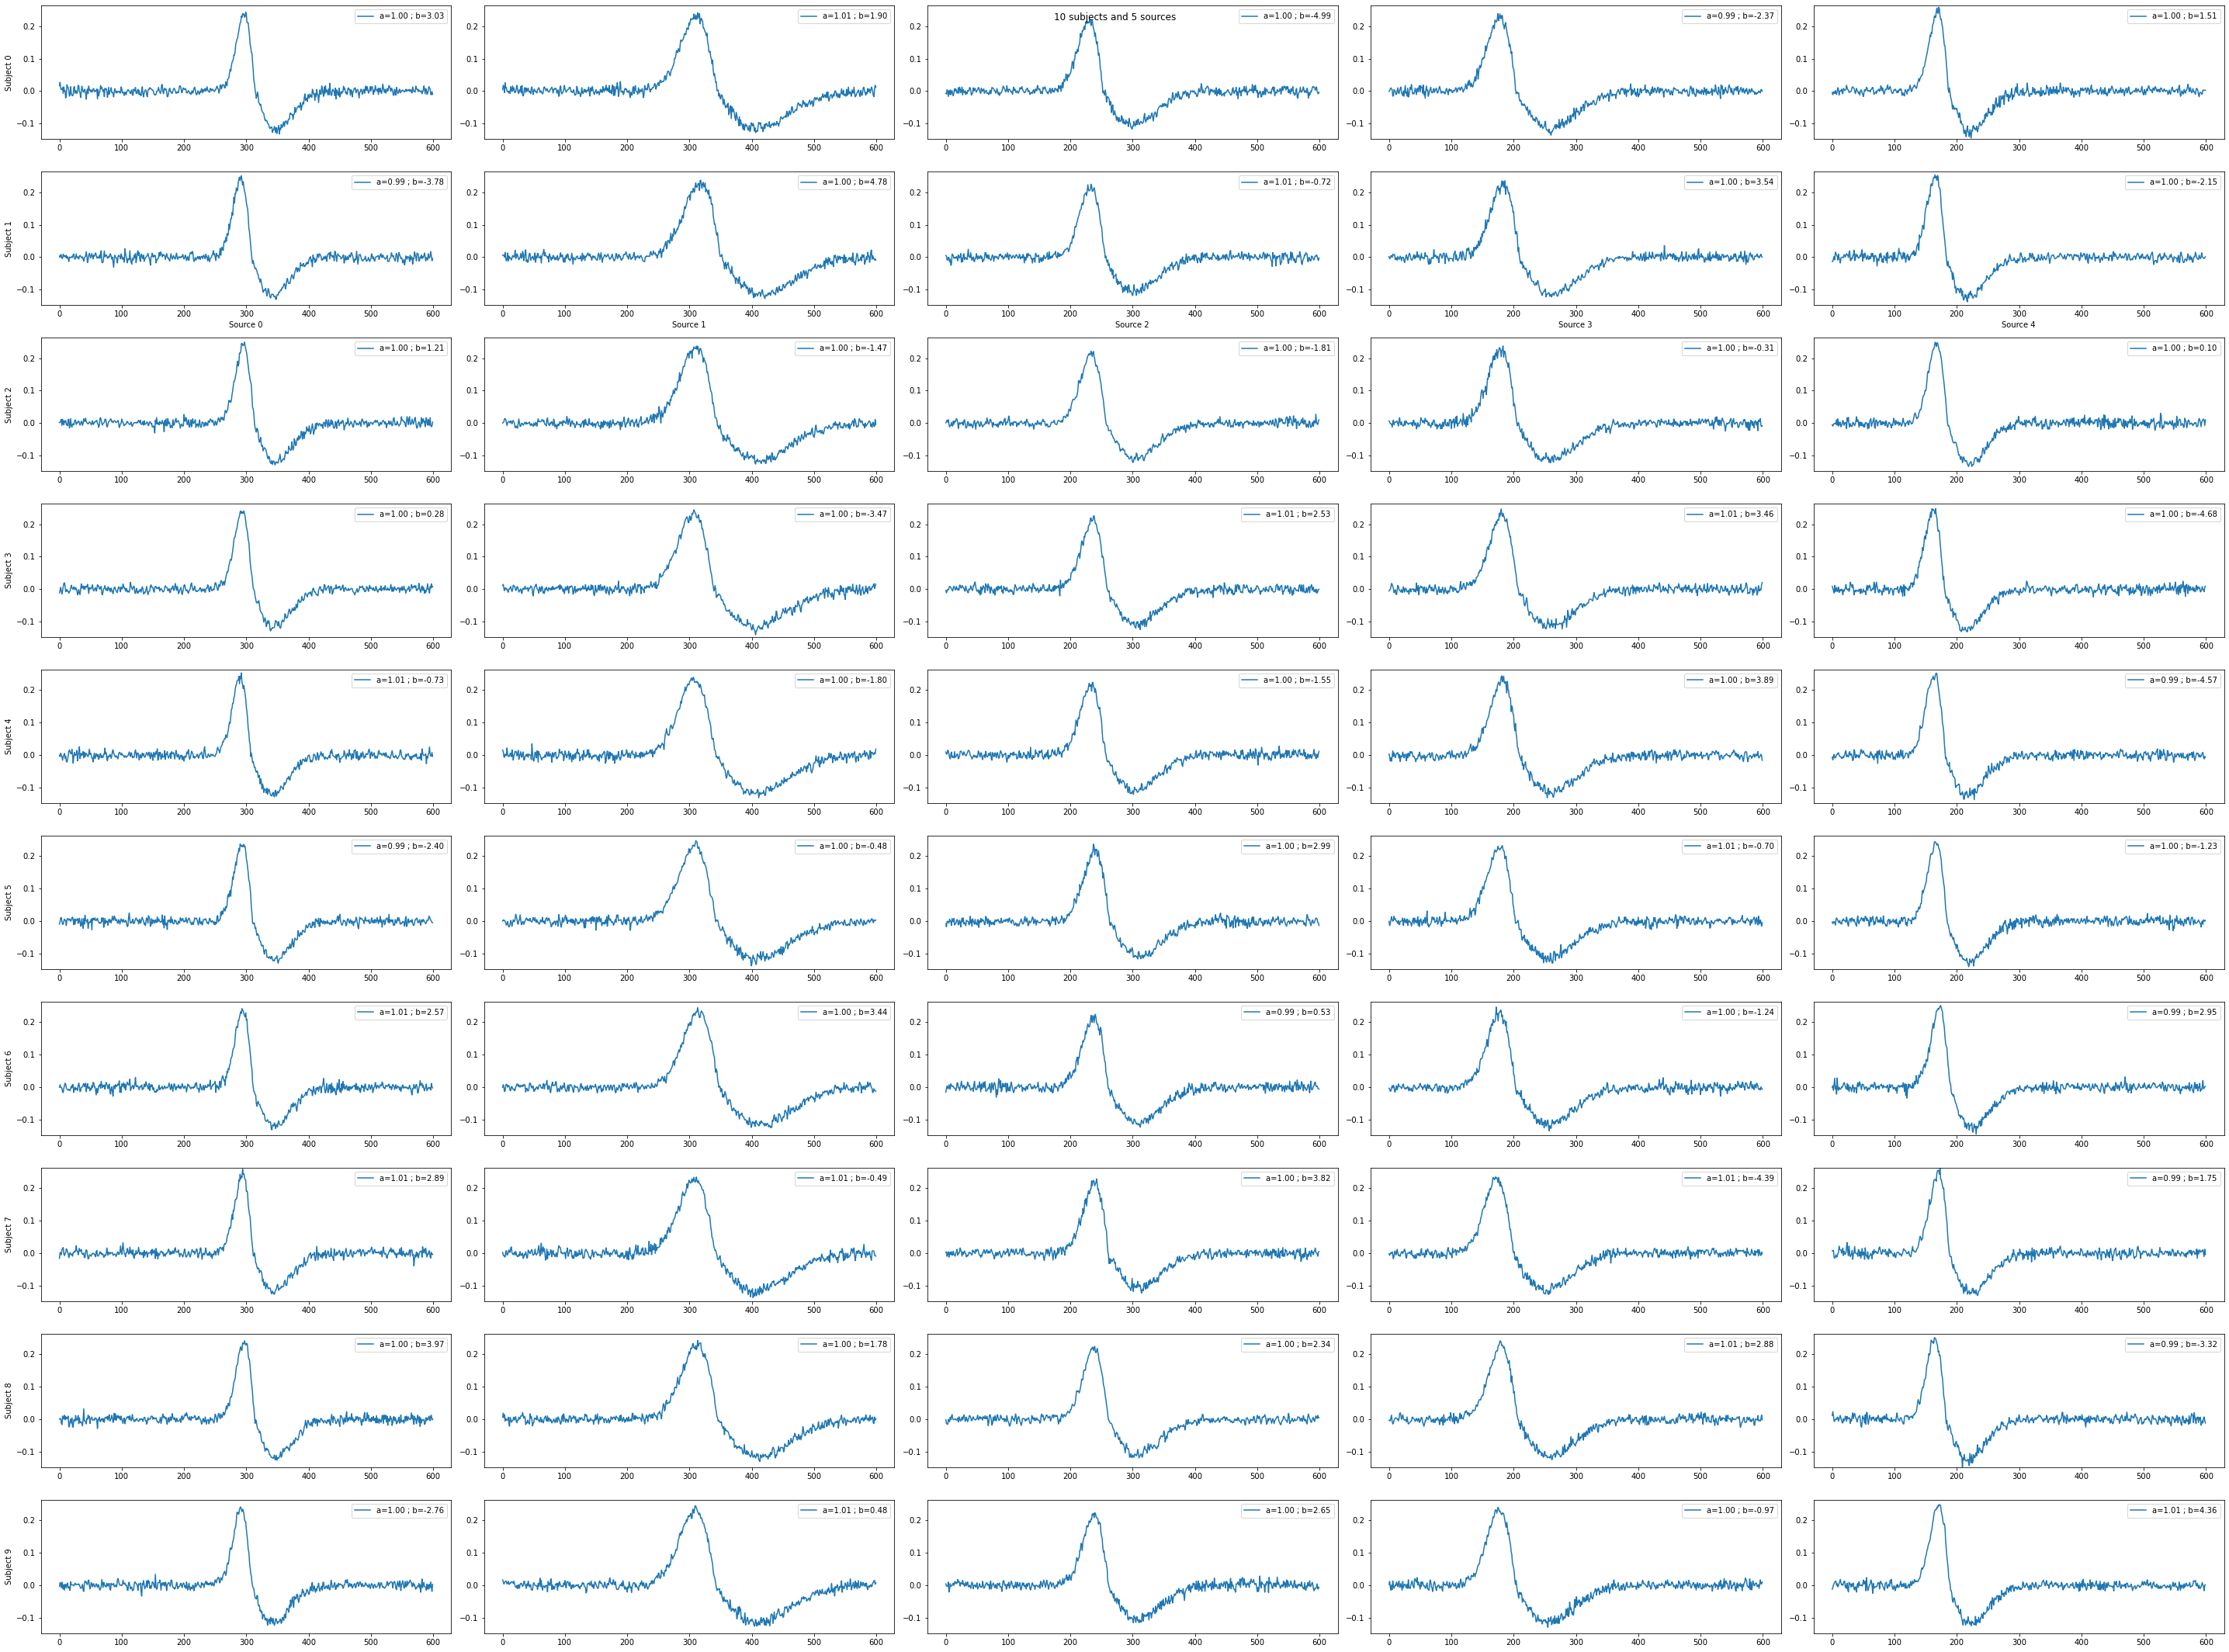

In [155]:
# plot 2 sources of 2 subjects
plt.subplots(m, p, figsize=(4*m, 6*p))

for i in range(m):
    for j in range(p):
        plt.subplot(m, p, p * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        # plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"{m} subjects and {p} sources")
plt.tight_layout()
plt.show()

# loss and grad

In [156]:
jax.config.update('jax_enable_x64', True)

In [157]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

def loss(W_list, X_list, noise_model=1):
    m, p, _ = X_list.shape
    W_list = W_list.reshape((m, p, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    S_avg = jnp.mean(S_list, axis=0)
    loss = jnp.mean(_logcosh(S_avg)) * p
    for W, Y in zip(W_list, S_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - S_avg) ** 2) * p
    return loss

In [158]:
val_and_grad = jax.jit(jax.value_and_grad(loss))

def wrapper_loss_and_grad(W_list, X_list, noise_model):
    loss, grad = val_and_grad(W_list, X_list, noise_model)
    return loss, np.array(grad)

# jit

In [159]:
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + noise_W_list * rng.randn(m, p, p)
W_list_init_ravel = jnp.ravel(W_list_init)

In [160]:
# jit
start = time()
wrapper_loss_and_grad(W_list_init_ravel, X_list, noise_model)
print(f"time : {time() - start}")

time : 3.7192299365997314


# LBFGSB

In [161]:
bounds_W = [(-jnp.inf, jnp.inf)] * m * p ** 2

In [162]:
class Memory_callback():
    def __init__(self):
        self.memory = []
    
    def __call__(self, W_list):
        self.memory.append(W_list.reshape((m, p, p)))

In [163]:
# LBFGSB
callback = Memory_callback()

res = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad,
    x0=W_list_init_ravel,
    args=(X_list, noise_model),
    bounds=bounds_W,
    disp=False,
    factr=1e11,
    pgtol=1e-8,
    callback=callback,
)

# MVICAD

In [164]:
# MVICAD
_, W_mvicad, _, _, _, _ = multiviewica_delay(
    X_list,
    init=W_list_init,
    shared_delays=False,
    max_delay=0,
    random_state=random_state,
    continuous_delays=False,
)

/Users/ambroiseheurtebise/Desktop/multiviewica_delay/multiviewica_delay/_multiviewica_delay.py:588: UserWarning: Multiview ICA has not converged - gradient norm: 1.621972e-02 
  warnings.warn(


# Amari distance

In [165]:
amari_mvicad = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)])
print(f"Amari distance MVICAD : {amari_mvicad}")

Amari distance MVICAD : 0.24988792768559143


In [166]:
W_list_rand = rng.randn(m, p, p)
amari_rand = np.mean([amari_distance(W, A) for W, A in zip(W_list_rand, A_list)])
print(f"Amari random : {amari_rand}")

Amari random : 0.9317228391105283


In [167]:
amari_distances = []
for W_list in tqdm(callback.memory):
    amari_distances.append(np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)]))

100%|██████████| 208/208 [00:00<00:00, 2190.30it/s]


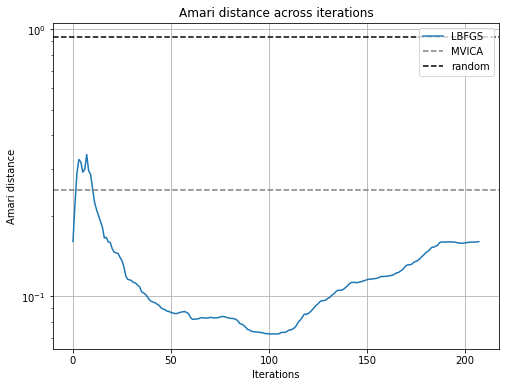

In [168]:
plt.figure(figsize=(8, 6))
plt.plot(amari_distances, label="LBFGS")
xmin, xmax = plt.xlim()
plt.hlines(y=amari_mvicad, xmin=xmin, xmax=xmax, linestyles='--', colors='grey', label="MVICA")
plt.hlines(y=amari_rand, xmin=xmin, xmax=xmax, linestyles='--', colors='k', label="random")
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Amari distance")
plt.title("Amari distance across iterations")
plt.xlim([xmin, xmax])
plt.legend()
plt.grid()